# Finding Magic: The Gathering archetypes with LDA: Code

This notebook is meant as a supplement for [this article](https://medium.com/@hlynurd/finding-magic-the-gathering-archetypes-with-latent-dirichlet-allocation-729112d324a6). The results were obtained by working with [this data](Modern.htm). 
You can try this method on data from other formats as well. There is an API on <a href="https://mtgdecks.net" rel="follow">MTG Decks</a> to access the latest 500 tournament decklists from <a href="https://mtgdecks.net/decks/csv/Standard" rel="follow">Standard</a>, <a href="https://mtgdecks.net/decks/csv/Modern" rel="follow">Modern</a>,
<a href="https://mtgdecks.net/decks/csv/Legacy" rel="follow">Legacy</a>, <a href="https://mtgdecks.net/decks/csv/Vintage" rel="follow">Vintage</a>, <a href="https://mtgdecks.net/decks/csv/Commander" rel="follow">Commander</a>, <a href="https://mtgdecks.net/decks/csv/Pauper" rel="follow">Pauper</a>, <a href="https://mtgdecks.net/decks/csv/Frontier" rel="follow">Frontier</a>, <a href="https://mtgdecks.net/decks/csv/Peasant" rel="follow">Peasant</a>  or <a href="https://mtgdecks.net/decks/csv/Highlander" rel="follow">Highlander</a>.

## Preparing the data

The usual first step of machine learning tasks is making sure that the data is in the right form for our algorithms. The raw data is a csv file where each line represents a decklist. Each line contains a main deck and sideboard:

In [5]:
with open('Modern.htm', 'r') as f:
    print(f.readline())

"4 Celestial Colonnade 1 Celestial Purge 3 Cryptic Command 2 Detention Sphere 1 Disdainful Stroke 1 Dispel 1 Elspeth, Sun's Champion 2 Field of Ruin 4 Flooded Strand 1 Geist of Saint Traft 2 Ghost Quarter 1 Gideon Jura 2 Gideon of the Trials 1 Gideon, Ally of Zendikar 3 Glacial Fortress 1 Grafdigger's Cage 1 Hallowed Fountain 5 Island 1 Jace, Architect of Thought 3 Leyline of Sanctity 3 Mana Leak 2 Negate 4 Path to Exile 3 Plains 2 Rest in Peace 1 Search for Azcanta 4 Serum Visions 3 Snapcaster Mage 1 Sphinx's Revelation 4 Spreading Seas 2 Stony Silence 3 Supreme Verdict 1 Temple of Enlightenment 1 Think Twice 1 Vendilion Clique"



We feed the data into a gensim Dictionary, similarly as in [this tutorial](https://radimrehurek.com/gensim/tut1.html). We split each decklist into individual cards, ignoring the card counts and cards that appear only once. 

In [7]:
import gensim
import json
import re 
from six import iteritems

In [84]:
with open('validated_decks.json') as f:
    j = json.load(f)
    card_dictionary = gensim.corpora.Dictionary([card.strip() for card in deck] for deck in j['decks'])
    
    # remove cards that appear only once
    once_ids = [tokenid for tokenid, docfreq in iteritems(card_dictionary.dfs) if docfreq == 1]
    card_dictionary.filter_tokens(once_ids)

    # remove gaps in id sequence after words that were removed
    card_dictionary.compactify()
    
    unique_cards = len(card_dictionary.keys())
    print('unique cards: ', unique_cards)

unique cards:  7743


In [85]:
# Original Implementation

#dictionary = gensim.corpora.Dictionary([x.strip() for x in re.split(r"[\d]+", line.replace("\"", ""))] for line in open('Modern.htm'))
#once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
#dictionary.filter_tokens(once_ids)  # remove cards that appear only once
#dictionary.compactify()  # remove gaps in id sequence after words that were removed

There are almost 700 cards in our modern-card dictionary:

In [86]:
# Original Implementation

#unique_cards = len(dictionary.keys())
#print(unique_cards)

Next we create a gensim Corpus. Instead of having a bag of words (cards) model, we take note how many times each card appears in a deck and "uncompress" the decklist description.

In [18]:
import numpy as np

In [88]:
class MyCorpus(object):
#    Original Implementation
#
#    def __iter__(self):
#        for line in open('Modern.htm'):
#            decklist = line.replace("\"", "") # remove start and end tokens            
#            decklist = re.split(r"([\d]+)", decklist) # split by numbers and card names
#            decklist = [x.strip() for x in decklist] # remove whitespace
#            decklist = list(filter(None, decklist)) # remove empty words
#            cleaned_decklist = [] 
#            for i in range(int(len(decklist)/2)): # remove numbers, add multiplicities of cards
#                for j in range(int(decklist[i*2])):
#                    cleaned_decklist.append(decklist[i*2+1])
#            yield dictionary.doc2bow(cleaned_decklist)
            
    def __iter__(self):
        with open('validated_decks.json') as f:
            j = json.load(f)
            
            for deck in j['decks']:
                cleaned_decklist = []
                for card_name in deck:
                    card_count = deck[card_name]
                    for i in range(card_count):
                        cleaned_decklist.append(card_name)
                yield card_dictionary.doc2bow(cleaned_decklist)
        
corpus_memory_friendly = MyCorpus()  

## Training the model
Now that the data is ready, we set the number of achetypes to be found. Setting it to 30 gave me good results. Try varying this and see what happens! 

In [89]:
archetypes = 30

Since there are stochastic steps in the training of the model, you might get slightly different results each time. Having the seed set to 1 allows you to recreate my results.

In [90]:
np.random.seed(1)

The "Latent Dirichlet" part of the method name comes from the assumption that the latent [priors](https://en.wikipedia.org/wiki/Prior_probability) on the per-archetype card distribution and per-decklist archetype distributions are [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution). This allows us to steer the learning of the model.

By incorporating such priors, we can tell the model how we believe the data actually looks like. If we have a large number of archetypes and are confident that each decklist only falls under one archetype, then setting a low alpha indicates that we prefer each decklist to belong to few, dominating archetypes. We can similarly control the archetype-card sparsity with beta. 


In [91]:
alpha_prior = [1.0 / archetypes] * archetypes
beta_prior = [1.0 / archetypes] * unique_cards

We finally train the model. This could take a couple of minutes.

In [93]:
iterations = 30
lda = gensim.models.ldamodel.LdaModel(corpus=corpus_memory_friendly, id2word=card_dictionary, num_topics=archetypes, passes=iterations, alpha = alpha_prior, eta = beta_prior)

## Checking the results

**Define Functions to convert card IDs to their name and picture**

https://img.scryfall.com/cards/normal/front/e/1/e19723ad-7bd2-49ee-a57a-ece99018f4e8.jpg?1538881020
Glaive of the Guildpact


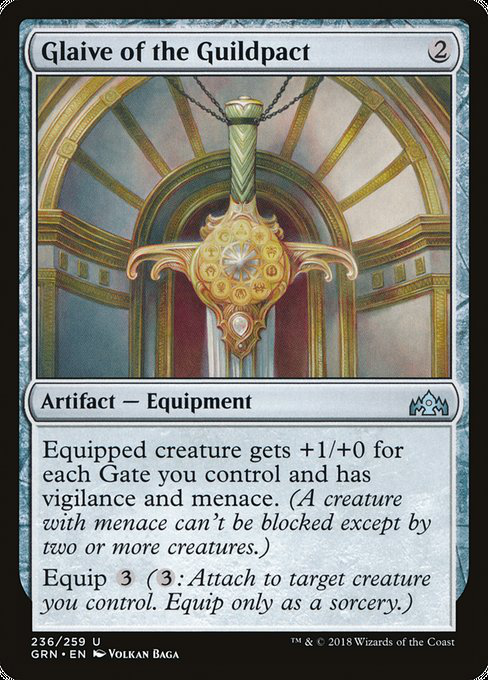

In [204]:
import requests
from PIL import Image
import requests
from io import BytesIO

def getCard(id):
    """
    Returns card JSON based on ID from Scryfall API
    """
    r = requests.get('https://api.scryfall.com/cards/multiverse/' + str(id))
    data = r.json()
    try:
        name = data['name']
    except KeyError:
        name = ''
    try:
        url = data['image_uris']['normal']
    except KeyError:
        url = ''
    return name, url

def getImage(url):
    """
    Returns "normal" image JPEG from Scryfall Image Library
    """
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

name, image_url = getCard(452986)
print(image_url)
print(name)
getImage(image_url)

A good rule of thumb while doing machine learning work is to do regular sanity checks. Anything from simple output prints to beautiful visualizations will help you understand what's going on. After the training is finished, we can explore the archetypes that it finds. Gensim offers a nice way to see the probability-card pairs in each archetype. 

In [95]:
number_of_top_cards = 16
archetypes_to_inspect = 3
for i in range(archetypes_to_inspect):
    print(("Archetype %i \n %s \n") % (i, lda.print_topic(i, topn=number_of_top_cards)))

Archetype 0 
 0.033*"442948" + 0.032*"442932" + 0.032*"442941" + 0.031*"442955" + 0.031*"442931" + 0.031*"442959" + 0.030*"442933" + 0.030*"442960" + 0.030*"442950" + 0.029*"442936" + 0.029*"442938" + 0.029*"442940" + 0.029*"442961" + 0.028*"442934" + 0.027*"442928" + 0.027*"442929" 

Archetype 1 
 0.009*"386646" + 0.009*"386652" + 0.008*"386479" + 0.008*"386599" + 0.008*"386530" + 0.008*"386722" + 0.007*"386535" + 0.007*"386584" + 0.007*"386536" + 0.007*"386656" + 0.007*"386473" + 0.007*"386690" + 0.007*"386705" + 0.007*"386582" + 0.007*"386558" + 0.007*"386688" 

Archetype 2 
 0.037*"447282" + 0.036*"447283" + 0.036*"447295" + 0.035*"447302" + 0.034*"447263" + 0.033*"447267" + 0.033*"447279" + 0.033*"447289" + 0.032*"447278" + 0.032*"447297" + 0.032*"447268" + 0.032*"447292" + 0.031*"447277" + 0.031*"447286" + 0.030*"447300" + 0.030*"447301" 



**Take a look at archetypes**

In [162]:
def print_archetype_topn(archetype_id, topn, show_name=True):
    """
    Print the top n most probable cards for an archetype.
    
    This function prints the card name when 'show_name'==True and the
    card_id when 'show_name'==False.
    """
    top_cards = np.array(lda.show_topic(archetype_id, topn=topn))
    for card in top_cards:
        if show_name:
            card_name = getCard(card[0])[0]
        else:
            card_name = card[0]
        card_prob = float(card[1])
        print('{:.4f} {}'.format(card_prob, card_name))

In [252]:
archetype_id = 13
topn = 30

print_archetype_topn(archetype_id, topn, show_name=False)

0.0322 447211
0.0319 447184
0.0313 447181
0.0310 447186
0.0292 447180
0.0290 447189
0.0289 447200
0.0285 447187
0.0281 447206
0.0280 447190
0.0280 447207
0.0278 447218
0.0274 447182
0.0274 447192
0.0272 447219
0.0271 447217
0.0265 447193
0.0249 447216
0.0246 447194
0.0175 447374
0.0123 447204
0.0117 447179
0.0117 447214
0.0114 447183
0.0106 447197
0.0106 447185
0.0102 447213
0.0102 447191
0.0101 447210
0.0101 447195


**Generate a Deck**

Since the model is generative, we can generate new decks as well. Here's an example of how to make a metagame altering affinity deck:

In [153]:
archetype_id = 10
archetype_topic = np.array(lda.show_topic(archetype_id, topn=9999))

archetype_distribution = np.array(archetype_topic[:,1], dtype="float32")
archetype_distribution = archetype_distribution / np.sum(archetype_distribution)

archetype_indices = np.zeros(len(archetype_distribution))
main_deck = 60
sideboard = 15
while np.sum(archetype_indices) < main_deck+sideboard:
    new_card = np.random.multinomial(1, archetype_distribution)
    archetype_indices += new_card
    if 5 in archetype_indices:
        archetype_indices -= new_card
archetype_cards = np.array(archetype_topic[:,0], dtype=np.unicode_)
minimum_cards = 1.0
deck_title = 'Archetype: {}'.format(archetype_id)
print(deck_title)
for i in range(len(archetype_distribution)):
    if archetype_indices[i] >= minimum_cards:        
        print('%i %s' % (archetype_indices[i], getCard(archetype_cards[i])[0]))

Archetype: 10
1 Take Vengeance
1 Gallant Cavalry
1 Star-Crowned Stag
2 Rustwing Falcon
2 Pegasus Courser
2 Daybreak Chaplain
3 Loxodon Line Breaker
1 Knight's Pledge
2 Cavalry Drillmaster
1 Mighty Leap
3 Angel of the Dawn
4 Knight of the Tusk
4 Oreskos Swiftclaw
3 Trusty Packbeast
4 Invoke the Divine
3 Revitalize
4 Luminous Bonds
1 Leonin Vanguard
1 Shield Mare
2 Make a Stand
2 Ajani's Pridemate
1 Ajani's Welcome
1 Aegis of the Heavens
3 Marauder's Axe
1 Heroic Reinforcements
1 Suncleanser
2 Cleansing Nova
1 Ajani's Last Stand
1 Remorseful Cleric
1 Satyr Enchanter
2 Mentor of the Meek
1 Skyscanner
1 Meandering River
1 Ghostform
1 Infernal Scarring
1 Lava Axe
1 Forest
1 Forest
1 Swamp
1 Scholar of Stars
1 Titanic Growth
1 Epicure of Blood
1 Disperse
1 Crucible of Worlds
1 Palladia-Mors, the Ruiner


## Exporting Archetypes

In [201]:
def export_archetypes():
    """
    Export the top most probable cards per archetype to a json file.
    """
    num_archetypes = 30
    num_cards = 30
    with open('30_archetypes.json', 'w') as f:
        archetypes_list = []
        for archetype_id in range(num_archetypes):
            archetype_json = {}
            archetype_json['archetype_id'] = archetype_id
            archetype_json['num_cards'] = num_cards
            archetype_json['cards'] = []
            for card_id, prob in np.array(lda.show_topic(archetype_id, topn=num_cards)):
                card_name, image_url = getCard(card_id)
                archetype_json['cards'].append({'card_id': card_id,
                                                'probability': prob,
                                                'card_name': card_name,
                                                'image_url': image_url})
            archetypes_list.append(archetype_json)
        json.dump(archetypes_list, f)

In [205]:
# Uncomment the line below to export archetypes
export_archetypes()

In [203]:
def print_deck_freq(archetype_num, filename):
    """
    Print out Archetype with name and card images
    """
    with open(filename, 'r') as f:
        card_dict = {}
        data = json.load(f)
        deck = data[archetype_num]
        for card in deck['cards']:
            name, image_url = getCard(card['card_id'])
            if name in card_dict:
                card_dict[name] += 1
            else:
                card_dict[name] = 1
        print(card_dict)

In [37]:
print_deck_freq(15, '30_archetypes.json')

Sacred Foundry
Camaraderie
Legion Warboss
Canal Monitor
Sworn Guardian
Sun-Crowned Hunters
Traveler's Amulet
Unfriendly Fire
Sure Strike
Swamp
Woodland Stream
Majestic Heliopterus
Charging Monstrosaur
Dinosaur Stampede
Marauding Looter
Sleek Schooner
Warkite Marauder
Rekindling Phoenix
Knight of Autumn
Dead Man's Chest
Daring Saboteur
Protean Raider
Chipper Chopper
Oaken Power Suit
Bumbling Pangolin
Overt Operative
Skull Saucer
Sly Spy
Tephraderm
Just Desserts
{'Sacred Foundry': 1, 'Camaraderie': 1, 'Legion Warboss': 1, 'Canal Monitor': 1, 'Sworn Guardian': 1, 'Sun-Crowned Hunters': 1, "Traveler's Amulet": 1, 'Unfriendly Fire': 1, 'Sure Strike': 1, 'Swamp': 1, 'Woodland Stream': 1, 'Majestic Heliopterus': 1, 'Charging Monstrosaur': 1, 'Dinosaur Stampede': 1, 'Marauding Looter': 1, 'Sleek Schooner': 1, 'Warkite Marauder': 1, 'Rekindling Phoenix': 1, 'Knight of Autumn': 1, "Dead Man's Chest": 1, 'Daring Saboteur': 1, 'Protean Raider': 1, 'Chipper Chopper': 1, 'Oaken Power Suit': 1, 'Bumb

## Judging Deck Archetypes

In [253]:
def get_deck_archetypes(deck, topn=5):
    """
    Return the top n archetypes of a deck.
    """
    deck_corpus = card_dictionary.doc2bow(deck)
    archetype_probs = lda.get_document_topics(deck_corpus)
    topn_archetypes = []
    for i in range(topn):
        highest = (-1, 0)
        for archetype_prob in archetype_probs:
            if archetype_prob[1] > highest[1]:
                highest = archetype_prob
        topn_archetypes.append(highest)
        archetype_probs.remove(highest)
    return topn_archetypes

query_deck = []
query_deck.append('447176')    # Top card from Archetype 10
query_deck.append('447148')    # 2nd top card from Archetype 10
print(get_deck_archetypes(query_deck))

[(10, 0.67777777), (0, 0.011111111), (1, 0.011111111), (2, 0.011111111), (3, 0.011111111)]
